What we get from this chapter

- roles of:
    - array
    - tensors
    - broadcasting
- Stochastic Gradient Descent: the mechanism for learning by updating weights automatically.
- The choice of a loss function for basic classification task
- The role of minibatches
- The math that a basic neural network is doing.

## Pixels: The Foundations of Computer Vision

In [1]:
from fastai.vision.all import *

In [2]:
# download a sample of MNIST
path = untar_data(URLs.MNIST_SAMPLE)

In [3]:
# checking directory
path.ls() # this method returns an object of a special fastai class called L

(#3) [Path('C:/Users/Kushan/.fastai/data/mnist_sample/labels.csv'),Path('C:/Users/Kushan/.fastai/data/mnist_sample/train'),Path('C:/Users/Kushan/.fastai/data/mnist_sample/valid')]

In [4]:
# look inside training set
(path/'train').ls()

(#2) [Path('C:/Users/Kushan/.fastai/data/mnist_sample/train/3'),Path('C:/Users/Kushan/.fastai/data/mnist_sample/train/7')]

In [5]:
# look inside 3s and 7s(labels/targets)
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('C:/Users/Kushan/.fastai/data/mnist_sample/train/3/10.png'),Path('C:/Users/Kushan/.fastai/data/mnist_sample/train/3/10000.png'),Path('C:/Users/Kushan/.fastai/data/mnist_sample/train/3/10011.png'),Path('C:/Users/Kushan/.fastai/data/mnist_sample/train/3/10031.png'),Path('C:/Users/Kushan/.fastai/data/mnist_sample/train/3/10034.png'),Path('C:/Users/Kushan/.fastai/data/mnist_sample/train/3/10042.png'),Path('C:/Users/Kushan/.fastai/data/mnist_sample/train/3/10052.png'),Path('C:/Users/Kushan/.fastai/data/mnist_sample/train/3/1007.png'),Path('C:/Users/Kushan/.fastai/data/mnist_sample/train/3/10074.png'),Path('C:/Users/Kushan/.fastai/data/mnist_sample/train/3/10091.png')...]

In [6]:
# it's full of image files, look at one now
im3_path = threes[1]
im3 = Image.open(im3_path) # Image class from Python Imaging Library(PIL)
im3

In [7]:
# To view the numbers that make up this image, have to convert it to a NumPy array or a PyTorch tensor
# a section of the image looks like converted to a NumPy array:
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [8]:
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [9]:
# slice the array to pick just the part with the top of the digit in it
# then use a Pandas DataFrame to color-code the values using a gradient
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


###### Q1: What kinds of features might it be able to look at? 
Ans: The features are as follow:
        - Shades 
        - Location
        
###### Q2: How might it be able to identify these features? 
Ans: In an array of shades of images.

###### Q3: How could it combine them? 
Ans: Combine the shades with the location of that pixel.

## First Try: Pixel Similarity
we find the average pixel value for every pixel of the 3s and 7s. This will give us two groups averages, defining what we might call the "ideal" 3 and 7. Then, to classify an image as one digit or the other, to see most similar.

In [10]:
# create a tensor containing all of our 3s stacked together
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors), len(seven_tensors)

(6131, 6265)

<AxesSubplot:>

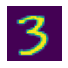

In [11]:
show_image(three_tensors[1])

To compute the average over all the images of the intensity of that pixel:
- Combine all the images in this list into a  single three-dimensional tensor(rank-3 tensor).
- Stack up individual tensors in a collection into a single tensor.
- Cast our stacked tensor to float.
- When images are floats, the pixel values are expected to be between 0 and 1, so we will also divide by 255.

In [12]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

In [13]:
# the length of a tensor's shape is its rank:
len(stacked_threes.shape), stacked_threes.ndim

(3, 3)

In [14]:
v = tensor([14, 56, 87])

In [15]:
v.shape

torch.Size([3])

In [16]:
v.ndim

1

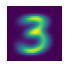

In [17]:
# Compute the ideal 3: calculate the mean of all the image tensors by taking the mean along dimension 0 of our stacked
mean3 = stacked_threes.mean(0)
show_image(mean3);

Peak number 3 performance looks like:
- Dark: where all the images agree it should be dark
- Wispy and Blurry: where the images disagree

<AxesSubplot:>

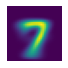

In [18]:
mean7 = stacked_sevens.mean(0)
show_image(mean7)

###### Q1. How would you calculate how similar a particular image is to each of our ideal digits? 
Ans: By finding maximum pixels close to dark pixel area

<AxesSubplot:>

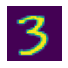

In [19]:
# sample 3
a_3 = stacked_threes[1]
show_image(a_3)

Data scientists use two main ways to measure distance in this context:
- Mean Absolute difference or L1 norm:
    - take the mean of the absolute(fn: -ve -> +ve) value of differences. 
- Root mean squared error or L2 norm
    - take mean of the square of differences (which makes everything positive)
    - take the square root (which undoes the squaring)

In [20]:
# try both:
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs, dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [21]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()

In both cases, the distance between our 3 and the “ideal” 3 is less than the distance to the ideal 7: loss function in Pytorch

In [22]:
F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3,mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

### NumPy Arrays and PyTorch Tensors

In [23]:
# To create an array or tensor, pass a list (or list of lists, or list of lists of lists, etc.) to array or tensor:
data = [[1,2,3],[4,5,6]]
arr = array(data)
tns = tensor(data)

arr # numpy

array([[1, 2, 3],
       [4, 5, 6]])

In [24]:
tns # pytorch

tensor([[1, 2, 3],
        [4, 5, 6]])

In [25]:
# select a row
tns[1]

tensor([4, 5, 6])

In [26]:
# column, by using : to indicate all of the first axis
tns[:,1]

tensor([2, 5])

In [27]:
# You can combine these with Python slice syntax ([start:end], with end being excluded) to select part of a row or column:

tns[1,1:3]

tensor([5, 6])

In [28]:
# use the standard operators, such as +, -, *, and /:
tns + 1

tensor([[2, 3, 4],
        [5, 6, 7]])

In [29]:
# Tensors have a type:
tns.type()

'torch.LongTensor'

### Computing Metrics Using Broadcasting

**Metric** is a number that is calculated based on the predictions of our model and the correct labels in our dataset

In [30]:
# create tensors for our 3s and 7s from Valid directory
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255

valid_3_tens.shape, valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [31]:
# define a notion of distance—that is, a function that calculates the distance between two images
def mnist_distance(a, b): return (a-b).abs().mean((-1, -2))
mnist_distance(a_3, mean3)

tensor(0.1114)

To calculate a metric for overall accuracy, we will need to calculate the distance to the ideal 3 for every image in the validation set.

How broadcasting is implemented:
- PyTorch doesn’t actually copy mean3 1,010 times. It pretends it were a tensor of that shape, but doesn’t allocate any additional memory.
- It does the whole calculation in C (or, if you’re using a GPU, in CUDA, the equiv‐ alent of C on the GPU), tens of thousands of times faster than pure Python (up to millions of times faster on a GPU!).

In [32]:
# mnist_distance to figure out whether an image is a 3
def is_3(x): return mnist_distance(x,mean3) < mnist_distance(x,mean7)

In [33]:
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [34]:
# broadcasting, we can also test it on the full validation set of 3s:
is_3(valid_3_tens)

tensor([ True,  True,  True,  ..., False,  True,  True])

Calculate the accuracy for each of the 3s and 7s, by taking the average of that function for all 3s and its inverse for all 7s:

In [35]:
accuracy_3s = is_3(valid_3_tens).float().mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s, accuracy_7s, (accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

## Stochastic Gradient Descent
Instead of trying to find the similarity between an image and an “ideal image,” we
could instead look at each individual pixel and come up with a set of weights for each.

To be more specific, here are the steps required to turn this function into a machine
learning classifier:
1. Initialize the weights.
2. For each image, use these weights to predict whether it appears to be a 3 or a 7.
3. Based on these predictions, calculate how good the model is (its loss).
4. Calculate the gradient, which measures for each weight how changing that weight would change the loss.
5. Step (that is, change) all the weights based on that calculation.
6. Go back to step 2 and repeat the process.
7. Iterate until you decide to stop the training process (for instance, because the model is good enough or you don’t want to wait any longer).

**Initialize**
    We initialize the parameters to random values.
   
**Loss**
    We need a function that will return a number that is small if the performance of the model is good.
    
**Step**
    A simple way to figure out whether a weight should be increased a bit or decreased a bit would be just to try it. As we will see, the magic of calculus allows us to directly figure out in which direction, and by roughly how much, to change each weight, without having to try all these small changes.
    
**Stop**
    Decided how many epochs to train the model for.

In [36]:
def plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, figsize=(6,4)):
    x = torch.linspace(min,max)
    fig,ax = plt.subplots(figsize=figsize)
    ax.plot(x,f(x))
    if tx is not None: ax.set_xlabel(tx)
    if ty is not None: ax.set_ylabel(ty)
    if title is not None: ax.set_title(title)

<ipython-input-36-23f717d23e3a>:2: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  ..\aten\src\ATen\native\RangeFactories.cpp:23.)
  x = torch.linspace(min,max)


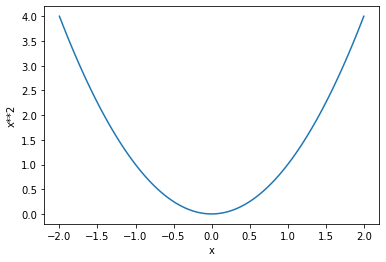

In [37]:
# let’s pretend that this is our loss function, and x is a weight parameter of the function:

def f(x): return x**2

# graph of that function:
plot_function(f, 'x', 'x**2')


The sequence of steps we described earlier starts by picking a random value for a parameter, and calculating the value of the loss:

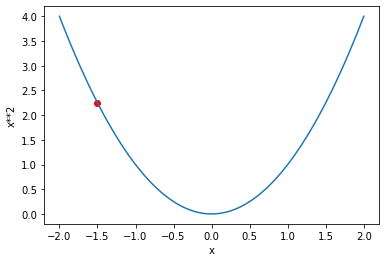

In [38]:
plot_function(f, 'x', 'x**2')
plt.scatter(-1.5, f(-1.5), color='red')

### Calculating Gradients
The gradients will tell us how much we have to change each weight to make our model better.

In [39]:
# First, let’s pick a tensor value at which we want gradients:
xt = tensor(3.).requires_grad_()

PyTorch prints not just the value calculated, but also a note that it has a gradient function it’ll be using to calculate our gradients when needed:

In [40]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

In [41]:
# Finally, we tell PyTorch to calculate the gradients for us:
yt.backward()

The “backward” here refers to backpropagation, which is the name given to the process of calculating the derivative of each layer.

In [42]:
# We can now view the gradients by checking the grad attribute of our tensor:
xt.grad

tensor(6.)

In [43]:
# repeat the preceding steps, but with a vector argument for our function:

xt = tensor([3., 4., 10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

In [44]:
# Add sum to our function so it can take a vector (i.e., a rank-1 tensor) and return a scalar (i.e., a rank-0 tensor):

def f(x): return (x**2).sum()

yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

In [45]:
# gradients are 2*xt, as we’d expect

yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

If the slope is very large, that may suggest that we have more adjustments to do, whereas if the slope is very small, that may suggest that we are close to the optimal value.

### Stepping with a Learning Rate
All approaches start with the basic idea of multiplying the gradient by some small number, called the learning rate (0.001 < LR < 0.1).

    w -= w.grad * lr
    
This is known as stepping your parameters, using an optimization step.

### An End-to-End SGD Example

In [46]:
# measuring the speed manually every second for 20 seconds, it might look something like this:

time = torch.arange(0, 20).float(); time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19.])

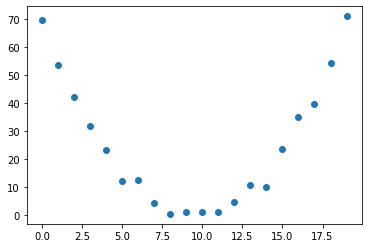

In [47]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time, speed);

Using SGD, we can try to find a function that matches our observations. let’s use a guess that it will be quadratic; i.e., a function of the form a x (time^2) + (b x time) + c.

In [48]:
def f(t, params):
    a,b,c = params
    return a*(t**2) + (b*t) + c

This greatly simplifies the problem, since every quadratic function is fully defined by the three parameters a, b, and c. Thus, to find the best quadratic function, we need to find only the best values for a, b, and c.

Let’s find the parameters for f first, and then we’ll come back and do the same thing for the MNIST dataset with a neural net.

We define this precisely by choosing a loss function, which will return a value based on a prediction and a target, where lower values of the function correspond to “better” predictions. For continuous data, it’s common to use mean squared error:

In [49]:
def mse(preds, targets): return ((preds-targets)**2).mean()

##### Step 1:Initialize the parameters
We initialize the parameters to random values and tell PyTorch that we want to
track their gradients using requires_grad_:

In [50]:
params = torch.randn(3).requires_grad_()

##### Step 2:Calculate the predictions
Calculate the predictions:

In [51]:
preds = f(time, params)

Create a little function to see how close our predictions are to our targets, and take a look:

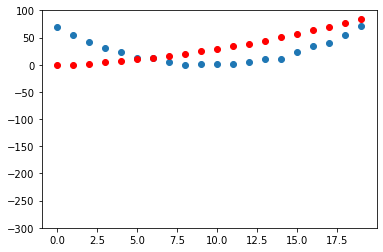

In [52]:
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300,100)
    
show_preds(preds)

##### Step 3:Calculate the loss
Calculate the loss as follows:

In [53]:
loss = mse(preds, speed)
loss

tensor(1044.2966, grad_fn=<MeanBackward0>)

Our goal is now to improve this. To do that, we’ll need to know the gradients.

##### Step 4: Calculate the gradients
The next step is to calculate the gradients, or an approximation of how the parame‐
ters need to change:

In [54]:
loss.backward()
params.grad

tensor([6411.7070,  435.6167,   14.3070])

In [55]:
params.grad * 1e-5

tensor([0.0641, 0.0044, 0.0001])

Use these gradients to improve our parameters. We’ll need to pick a learning rate.

In [56]:
params

tensor([ 0.1677,  1.3343, -1.1511], requires_grad=True)

##### Step 5: Step the weights
Now we need to update the parameters based on the gradients we just calculated:

In [57]:
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None

In [58]:
# let's see if the loss is improved:
preds = f(time,params)
mse(preds, speed)

tensor(747.9659, grad_fn=<MeanBackward0>)

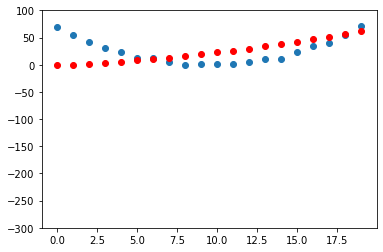

In [59]:
# And take a look at the plot:
show_preds(preds)

In [60]:
# We need to repeat this a few times, so we’ll create a function to apply one step:
 
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

##### Step 6: Repeat the process
Now we iterate. By looping and performing many improvements, we hope to reach a good result:

In [61]:
for i in range(10): apply_step(params)

747.9659423828125
691.884765625
681.2664184570312
679.2507934570312
678.8630981445312
678.7835083007812
678.7621459960938
678.7518310546875
678.7435913085938
678.7357788085938


We can see this process visually, Then we can see how the shape is approaching the best possible quadratic function for our data:

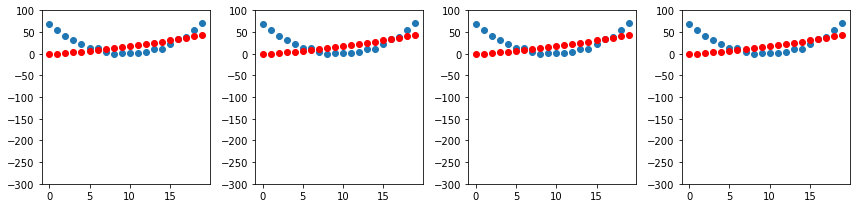

In [62]:
_, axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

##### Step 7: Stop
We just decided to stop after 10 epochs arbitrarily. In practice, we would watch the training and validation losses and our metrics to decide when to stop

## The MNIST Loss Function
- We’ll concatenate them all into a single tensor
- Change them from a list of matrices (a rank-3 tensor) to a list of vectors (a rank-2 tensor).

Using view, which is a PyTorch method that changes the shape of a tensor without changing its contents. -1 is a special parameter to view that means “make this axis as big as necessary to fit all the data”:

In [63]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

We need a label for each image. We’ll use 1 for 3s and 0 for 7s:

In [64]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)

train_x.shape, train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [65]:
# A Dataset in PyTorch is required to return a tuple of (x,y) when indexed.

dset = list(zip(train_x,train_y))
x,y = dset[6000]
x.shape,y

(torch.Size([784]), tensor([1]))

In [66]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

In [67]:
# Initialize random weight for every pixel:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

weights = init_params((28*28,1))

For protecting y to become 0 if x is 0. y=w*x+b; we still need the b. We’ll initialize it to a random number too:

In [68]:
bias = init_params(1)

In neural networks, the w in the equation y=w*x+b is called the weights, and the b is called the bias. Together, the weights and bias make up the parameters

In [69]:
# calculate a prediction for one image:
(train_x[0]*weights.T).sum() + bias

tensor([-4.6767], grad_fn=<AddBackward0>)

In [70]:
# In Python, matrix multiplication is represented with the @ operator. Let’s try it:

def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[-4.6767],
        [ 1.7189],
        [-2.5004],
        ...,
        [ 8.8269],
        [-3.2641],
        [13.3538]], grad_fn=<AddBackward0>)

In [71]:
corrects = (preds>0.0).float() == train_y
corrects

tensor([[False],
        [ True],
        [False],
        ...,
        [False],
        [ True],
        [False]])

In [72]:
corrects.float().mean().item()

0.4678122103214264

In [73]:
# let’s see what the change in accuracy is for a small change in one of the weights:

weights[0] *= 1.0001

preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

RuntimeError: a view of a leaf Variable that requires grad is being used in an in-place operation.

In [74]:
with torch.no_grad():
    weights[0] *= 1.0001
    

In [75]:
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

0.4678122103214264

###### SGD > gradient > loss function
Loss Function receives:    
- Predictions: one argument, prds: 0 < prds < 1 : rank-1 tensor
- Targets(labels): another argument, trgts: 0 or 1 : rank-1 tensor

In [76]:
trgts = tensor([1,0,1])
prds = tensor([0.9, 0.4, 0.2])

In [77]:
# a loss function that measures the distance between predictions and targets:

def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

This function will measure how distant each prediction is from 1 if it should be 1, and how distant it is from 0 if it should be 0, and then it will take the mean of all those distances.

In [78]:
# try it on our prds and trgts:
torch.where(trgts==1, 1-prds, prds)

tensor([0.1000, 0.4000, 0.8000])

In [79]:
# scalar for the final loss, mnist_loss takes the mean of the previous tensor:
mnist_loss(prds,trgts)

tensor(0.4333)

change our prediction for the one “false” target from 0.2 to 0.8, the loss will go down, indicating that this is a better prediction:

In [80]:
mnist_loss(tensor([0.9,0.4,0.8]),trgts)

tensor(0.2333)

### Sigmoid
The sigmoid function always outputs a number between 0 and 1. It’s defined as follows:

In [81]:
def sigmoid(x): return 1/(1+torch.exp(-x))

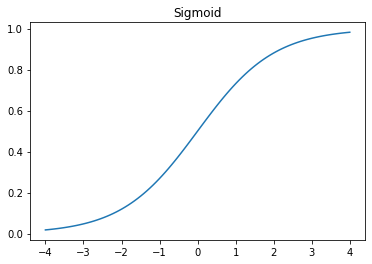

In [82]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

It takes any input value, positive or negative, and smooshes it into an output value between 0 and 1.

In [83]:
# update mnist_loss to first apply sigmoid to the inputs:

def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

Loss function will work, even if the predictions are not
between 0 and 1. All that is required is that a higher prediction corresponds to higher
confidence.

Metric is to drive human understanding and the loss is to drive automated learning.

We learn to focus on these metrics, rather than the loss, when judging
the performance of a model.

### SGD and Mini-Batches
To change or update the weights based on the gradients. This is called an optimization step.

To take an optimization step, we need to calculate the loss over one or more data items. Calculating whole dataset or single item is not Ideal. So we use few data at a time: mini-batch (no. of data items: batch size)

PyTorch and fastai provide a class that will do the shuffling and mini-batch collation for you, called DataLoader.

In [84]:
# A DataLoader can take any Python collection and turn it into an iterator over many batches, like so:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([ 3, 11,  4,  7, 13]),
 tensor([ 0,  2, 14, 12,  5]),
 tensor([ 9,  8,  6, 10,  1])]

For training a model, a collection containing independent and dependent variables (the inputs and targets of the model). A collection that contains tuples of independent and dependent variables is known in PyTorch as a Dataset

In [85]:
# example of an extremely simple Dataset:

ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

In [86]:
# pass a Dataset to a DataLoader:
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[(tensor([ 7,  9, 18, 10, 21, 15]), ('h', 'j', 's', 'k', 'v', 'p')),
 (tensor([16, 20, 12,  5,  0,  2]), ('q', 'u', 'm', 'f', 'a', 'c')),
 (tensor([ 4, 13, 19, 11,  6, 24]), ('e', 'n', 't', 'l', 'g', 'y')),
 (tensor([25, 23,  8, 17,  1, 22]), ('z', 'x', 'i', 'r', 'b', 'w')),
 (tensor([ 3, 14]), ('d', 'o'))]

## Putting It All Together

In [87]:
# In code, our process will be implemented something like this for each epoch:

for x,y in dl:
    pred = model(x)
    loss = loss_func(pred, y)
    loss.bachward()
    parameters -= parameters.grad * lr

NameError: name 'model' is not defined

In [88]:
# First, let’s reinitialize our parameters:

weights = init_params((28 * 28, 1))
bias = init_params(1)

In [89]:
# A DataLoader can be created from a Dataset:
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [90]:
# We’ll do the same for the validation set:

valid_dl = DataLoader(valid_dset, batch_size=256)

In [91]:
# Let's create a mini-batch of size 4 for testing:

batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [92]:
preds = linear1(batch)
preds

tensor([[-27.3501],
        [-29.2108],
        [-18.2972],
        [-22.8321]], grad_fn=<AddBackward0>)

In [93]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(1., grad_fn=<MeanBackward0>)

In [94]:
# Now we can calculate the gradients:

loss.backward()
weights.grad.shape, weights.grad.mean(), bias.grad

(torch.Size([784, 1]), tensor(-4.1113e-10), tensor([-2.8594e-09]))

In [95]:
# Let’s put that all in a function:

def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [96]:
# And test it:

calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-8.2226e-10), tensor([-5.7188e-09]))

In [97]:
# But look what happens if we call it twice:

calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(), bias.grad

(tensor(-1.2334e-09), tensor([-8.5782e-09]))

The gradients have changed! The reason for this is that loss.backward adds the gradients of loss to any gradients that are currently stored. 

In [98]:
# set the current gradients to 0 first:

weights.grad.zero_()
bias.grad.zero_();

Update the weights and biases based on the gradient and learning rate. When we do so, we have to tell PyTorch not to take the gradient of this step too. If we assign to the data attribute of a tensor, PyTorch will not take the gradient of that step.

In [99]:
# basic training loop for an epoch:

def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb,yb,model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

To decide if an output represents a 3 or a 7, we can just check whether it’s greater than 0.

In [100]:
# accuracy for each item can be calculated as follows:

(preds>0.0).float() == train_y[:4]

tensor([[False],
        [False],
        [False],
        [False]])

In [101]:
# That gives us this function to calculate our validation accuracy:

def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [102]:
# We can check it works:

batch_accuracy(linear1(batch), train_y[:4])

tensor(0.)

In [103]:
# And then put the batches together:

def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

validate_epoch(linear1)

0.5047

In [104]:
# That’s our starting point. Let’s train for one epoch and see if the accuracy improves:

lr = 1
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.5752

In [105]:
# Then do a few more:

for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.7709 0.8813 0.9194 0.9413 0.9501 0.955 0.9579 0.9594 0.9623 0.9638 0.9643 0.9653 0.9667 0.9687 0.9687 0.9697 0.9697 0.9707 0.9712 0.9731 

Our next step will be to create an object that will handle the SGD step for us. In PyTorch, it’s called an optimizer.

### Creating an Optimizer

The first thing we can do is replace our linear function with PyTorch’s nn.Linear module. A module is an object of a class that inherits from the PyTorch nn.Module class.

nn.Linear = init_params + linear

In [ ]:
linear_model = nn.Linear(28*28,1)

In [ ]:
# Parameters are available through the parameters method:

w, b = linear_model.parameters()
w.shape,b.shape

In [ ]:
# We can use this information to create an optimizer:

class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr
        
    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr
            
    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

In [ ]:
# We can create our optimizer by passing in the model’s parameters:

opt = BasicOptim(linear_model.parameters(), lr)

In [ ]:
# Out training loop can now be simplified:

def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [ ]:
# Our validation function doesn’t need to change at all:

validate_epoch(linear_model)

In [ ]:
# Let’s put our little training loop in a function, to make things simpler:

def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [ ]:
# The results are the same as in the previous section:

train_model(linear_model, 20)

In [ ]:
# fastai provides the SGD class that, by default, does the same thing as our BasicOptim:

linear_model = nn.Linear(28*28, 1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

fastai also provides Learner.fit, which we can use instead of train_model

In [ ]:
# To create a Learner, we first need to create a DataLoaders, by passing in our training and validation DataLoaders:

dls = DataLoaders(dl, valid_dl)

In [ ]:
# create a Learner without using an application

learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD, loss_func=mnist_loss, metrics=batch_accuracy)

In [ ]:
# Now we can call fit:

learn.fit(10, lr=lr)

## Adding a Nonlinearity

In [ ]:
# Here is the entire definition of a basic neural network:

def simple_net(xb):
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

In [ ]:
#  w1 has 30 output activations (which means that w2 must have 30 input activations, so they match). 
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

In [ ]:
# function res.max(tensor(0.0)) is called a rectified linear unit, also known as ReLU

plot_function(F.relu)

For any arbitrarily wiggly function, we can approximate it as a bunch of lines joined together; to make it closer to the wiggly function, we just have to use shorter lines. This is known as the universal approximation theorem.

The three lines of code that we have here are known as layers.

The first and third are known as linear layers, and the second line of code is known variously as a nonlinearity, or activation function.

In [ ]:
# we can replace this code with something a bit simpler by taking advantage of PyTorch:

simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [ ]:
# this is a deeper model, we’ll use a lower learning rate and a few more epochs:

learn = Learner(dls, simple_net, opt_func=SGD, loss_func=mnist_loss, metrics=batch_accuracy)

learn.fit(40,0.1)

In [ ]:
# the training process is recorded in learn.recorder, so we can plot the accuracy over training:

plt.plot(L(learn.recorder.values).itemgot(2));

In [ ]:
# And we can view the final accuracy:

learn.recorder.values[-1][2]

At this point, we have something that is rather magical:
- A function that can solve any problem to any level of accuracy (the neural network) given the correct set of parameters
- A way to find the best set of parameters for any function (stochastic gradient descent)

### Going Deeper

In [ ]:
# Here is what happens when we train an 18-layer model using the same approach we saw in Chapter 1:

# dls = ImageDataLoaders.from_folder(path)
# learn = cnn_learner(dls, resnet18, pretrained=False, loss_func=F.cross_entropy, metrics=accuracy)
# learn.fit_one_cycle(1,0.1)